In [1]:
#%matplotlib widget

In [2]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_simple
import ariel_gp
import ariel_load
import ariel_load_FGS
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import importlib
from tqdm import tqdm
import seaborn as sns
import pandas as pd
kgs.debugging_mode = 1
kgs.profiling=False
kgs.n_workers = 6

local


In [3]:
train_data = kgs.load_all_train_data()
train_data = train_data

# t = []
# for ind in range(len(train_data)):
#     if ind not in [999, 114, 21, 647, 146, 147, 897, 364, 553, 1013, 264, 90, 931, 697, 501, 288, 689, 892, 64, 251, 298, 876, 886, 494, 220, 398, 16, 727, 277, 1067, 1021, 240, 1002, 809, 460, 665, 679, 729, 1049, 989, 383, 531, 305, 1025, 401, 838, 99, 163, 1055, 695, 894, 750, 111, 418, 328, 403, 680, 171, 683, 877, 761, 765, 956, 119, 618, 216, 60, 9, 0, 159, 1091, 112, 422, 885, 229, 140, 568, 787, 11, 686, 563, 53, 1063, 636, 107, 737, 700, 795, 646, 1022, 712, 375, 333, 516, 185, 441, 656, 237, 262, 306, 408, 992, 893, 869, 954, 978, 285, 487, 601, 642, 245, 72, 484, 582, 1065, 933, 129, 591, 476, 393, 430, 784, 373, 722, 965, 263, 366, 379, 807, 479, 570, 349, 760, 782, 184, 1030, 998, 546, 337, 888, 477, 547, 23, 371, 678, 311, 669, 440, 505, 196, 720, 425, 75, 174, 44, 969, 100, 78, 120, 475, 578, 361, 536, 653, 688, 810, 1058, 213, 294, 96, 1031, 758, 708, 733, 362, 135, 734, 847, 485, 619, 17, 709, 161, 823, 826, 677, 152, 794, 1028, 812, 739, 1001, 907, 19, 879, 698, 202, 192, 793, 1024, 467, 803, 870, 66, 178, 416, 801, 816, 658, 592, 249, 439, 663, 160, 1047, 492, 786, 74, 604, 993, 219, 673, 593, 59, 836, 1088, 1075, 325, 588, 208, 151, 961, 913, 873, 321, 740, 951, 1066, 514, 271, 799, 137, 206, 675, 518, 724, 508, 341, 735, 387, 555, 864, 935, 538, 815, 198, 180, 549, 820, 327, 93, 899, 390, 667, 117, 903, 1057, 906, 701, 87, 909, 470, 421, 449, 290, 47, 88, 641, 783, 270, 754, 128, 703, 404, 845, 1004, 385, 314, 842, 1027, 606, 378, 228, 257, 101, 338, 193, 1000, 829, 519, 529, 156, 209, 13, 497, 1046, 438, 230, 624, 704, 970, 496, 164, 772, 70, 692, 384, 736, 824, 1094, 136, 948, 1051, 639, 901, 307, 912, 650, 1054, 696, 279, 169, 199, 22, 1042, 269, 201, 796, 278, 1036, 941, 891, 396, 716, 410, 920, 575, 255, 778, 1081, 925, 562, 963, 372, 367, 212, 567, 1038, 472, 571, 730, 153, 916, 144, 942, 442, 1095, 613, 1092, 713, 92, 1079, 910, 166, 89, 629, 2, 884, 177, 651, 447, 702, 655, 344, 203, 725, 412, 319, 622, 602, 572, 108, 448, 27, 217, 323, 461, 149, 865, 975, 18, 83, 875, 973, 530, 62, 732, 145, 603, 915, 902, 950, 431, 972, 97, 959, 693, 415, 246, 839, 874, 1093, 343, 28, 905, 286, 86, 445, 738, 871, 611, 962, 503, 806, 856, 292, 468, 256, 539, 122, 348, 459, 515, 707, 374, 466, 1015, 493, 825, 881, 1084, 615, 46, 31, 58, 427, 576, 500, 747, 797, 483, 790, 406, 690, 889, 197, 79, 805, 977, 605, 517, 155, 682, 559, 581, 423, 315, 284, 76, 830, 310, 313, 7, 946, 513, 584, 347, 560, 1006, 932, 649, 1052, 424, 138, 26, 247, 749, 640, 955, 533, 580, 499, 1034, 666, 200, 785, 1040, 645, 1041, 545, 317, 345, 30, 543, 952, 259, 8, 464, 296, 148, 369, 187, 995, 242, 880, 426, 322, 757, 1087, 607, 450, 743, 14, 167, 265, 1008, 131, 69, 471, 55, 126, 1062, 91, 481, 831, 486, 623, 726, 985, 35, 282, 173, 346, 186, 1043, 37, 990, 1048, 813, 670, 746, 1017, 363, 252, 504, 612, 32, 718, 569, 326, 768, 866, 1064, 110, 631, 420, 332, 142, 20, 643, 1016, 742, 443, 984, 986, 1069, 828, 551, 510, 316, 234, 921, 261, 744, 764, 851, 154, 859, 561, 1020, 583, 253, 940, 821, 684, 254, 832, 699, 846, 918, 50, 949, 565, 172, 81, 473, 42, 506, 1053, 896, 634, 488, 706, 774, 113, 710, 352, 376, 526, 1039, 857, 1086, 304, 862, 1050, 1083, 218, 957, 48, 127, 102, 280, 51, 895, 359, 858, 238, 1090, 324, 105, 930, 776, 210, 1071, 632, 741, 444, 405, 944, 339, 791, 964, 971, 745, 189, 370, 293, 224, 1033, 437, 960, 241, 759, 236, 115, 1023, 861, 301, 509, 586, 103, 190, 715, 239, 451, 205, 77, 150, 434, 104, 409, 756, 157, 927, 853, 924, 1056, 121, 223, 250, 318, 56, 542, 1, 751, 600, 608, 926, 994, 878, 1011, 226, 585, 635, 182, 436, 541, 522, 266, 482, 227, 132, 819, 911, 779, 798, 388, 134, 1098, 287, 162, 15, 1035, 52, 65, 395, 94, 773, 843, 1096, 934, 685, 480, 428, 590, 235, 867, 130, 728, 175, 433, 243, 106, 868, 399, 1029, 411, 456, 633, 616, 368, 281, 674, 900, 637, 498, 1072, 827, 57, 188, 143, 664, 354, 991, 158, 817, 534, 351, 392, 495, 25, 630, 380, 24, 676, 802, 1007, 231, 29, 947, 1018, 1073, 248, 232, 939, 863, 850, 691, 587, 356, 1085, 489, 33, 4, 407, 195, 943, 1070, 54, 579, 609, 835, 917, 353, 457, 520, 537, 748, 833, 837, 276, 469, 525, 980, 1019, 40, 1089, 465, 771, 272, 331, 80, 966, 6, 299, 852, 511, 808, 233, 68, 781, 67, 919, 260, 413, 769, 302, 654, 139, 183, 303, 557, 360, 532, 308, 41, 1009, 890, 453, 694, 458, 723, 12, 979, 1082, 312, 714, 168, 540, 49, 620, 860, 381, 717, 267, 594, 804, 1044, 377, 770, 141, 854, 336, 342, 898, 400, 883, 814, 84, 626, 625, 659, 752, 507, 61, 904, 391, 268, 211, 512, 221, 283, 687, 124, 3, 116, 638, 958, 614, 214, 1074, 179, 988, 953, 454, 844, 822, 98, 1037, 1060, 660, 358, 222, 181, 573, 258, 340, 382, 1014, 767, 1026, 550, 225, 937, 45, 291, 355, 191, 194, 922, 762, 300, 320, 766, 274, 474, 389, 661, 657, 295, 1068, 564, 1059, 10, 502, 711, 908, 297, 1078, 841, 1061, 165, 628, 544, 527, 789, 95, 478, 82, 71, 719, 753, 244, 981, 419, 983, 402, 929, 800, 763, 455, 668, 968, 974, 662, 914, 528, 34, 840, 617, 463, 599, 435, 535, 207, 36, 491, 63, 597, 627, 432, 446, 621, 462, 610, 644, 574, 882, 589, 275, 133, 386, 1005, 872, 125, 566, 5, 523, 524, 123, 452, 834, 1076, 1032, 777, 938, 848, 681, 43, 554, 204, 928, 976, 982, 577, 775, 987, 996, 923, 671, 170, 731, 855, 397, 109, 755, 1080, 705, 38]:
#         t.append(train_data[ind])
# train_data = t
# train_data_multi = []
# train_data_single = []
# for d in train_data:
#     if len(d.transits)==1:
#         train_data_single.append(d)
#     else:
#         train_data_multi.append(d)
# len(train_data_multi), len(train_data_single)

# train_data = train_data_multi

In [4]:
# importlib.reload(kgs)
# for d in train_data:
#     d.spectrum_cov = np.ones((283,283))
# kgs.mats_to_data(train_data, train_data, kgs.data_to_mats(train_data,train_data))
# kgs.score_metric(train_data, train_data)

In [5]:
importlib.reload(ariel_model)
todo = dict()

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# todo['New transit prior, alpha=1.0, FGSs=0.0001'] = model

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# todo['New baseline fudger2 coupling'] = model



# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# model.model.model_options.unregularize_transit = True
# todo['Unregularize transit'] = model

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# model.model.model_options.unregularize_transit = True
# todo['Unregularize transit alt'] = model

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# model.model.model_options.transit_std_scaling = 0.1
# todo['std scaling 0.1'] = model

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# model.model.model_options.transit_std_scaling = 0.1
# model.model.model_options.n_iter = 7
# todo['std scaling 0.1, 7 iters'] = model

# model = ariel_model.baseline_model()
# starter_model = ariel_simple.SimpleModel()
# starter_model.unlock_t0 = True
# starter_model.new_solver = False
# for ii in range(2):
#     starter_model.loaders[ii].apply_pixel_corrections.remove_last_frame = True
#     starter_model.loaders[ii].apply_pixel_corrections.new_cosmic_ray_removal = True
#     starter_model.loaders[ii].apply_time_binning.add_last_frame=True
#     #model.loaders[ii].apply_pixel_corrections.cosmic_ray_threshold = 10
# model.model.starter_model = ariel_simple.SimpleModelChainer(model=starter_model)
# model.model.train(kgs.load_all_train_data())
# todo['New loader and new simple solver'] = model

model = ariel_model.baseline_model()
starter_model = ariel_simple.SimpleModel()
starter_model.unlock_t0 = True
starter_model.new_solver = False
for ii in range(2):
    starter_model.loaders[ii].apply_pixel_corrections.remove_last_frame = True
    starter_model.loaders[ii].apply_pixel_corrections.new_cosmic_ray_removal = True
    starter_model.loaders[ii].apply_time_binning.add_last_frame=True
    #model.loaders[ii].apply_pixel_corrections.cosmic_ray_threshold = 10
model.model.starter_model = ariel_simple.SimpleModelChainer(model=starter_model)
model.model.model_options.common_parameters = [1,2,3]
model.model.train(kgs.load_all_train_data())
todo['New loader and new simple solver + unlock t0'] = model

model = ariel_model.baseline_model()
starter_model = ariel_simple.SimpleModel()
starter_model.unlock_t0 = True
starter_model.new_solver = False
for ii in range(2):
    starter_model.loaders[ii].apply_pixel_corrections.remove_last_frame = True
    starter_model.loaders[ii].apply_pixel_corrections.new_cosmic_ray_removal = True
    starter_model.loaders[ii].apply_time_binning.add_last_frame=True
    #model.loaders[ii].apply_pixel_corrections.cosmic_ray_threshold = 10
model.model.starter_model = ariel_simple.SimpleModelChainer(model=starter_model)
model.model.model_options.common_parameters = [1,2,3]
model.model.model_options.FGS_transit_override = ('linear', 1)
model.model.model_options.AIRS_transit_override = ('linear', 1)
model.model.train(kgs.load_all_train_data())
todo['New loader and new simple solver + unlock t0, linear'] = model

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# todo['Baseline'] = model
# model = ariel_model.baseline_model()
# model.model.model_options.transit_std_scaling = 1.
# starter_model = ariel_simple.SimpleModel()
# starter_model.unlock_t0 = True
# starter_model.new_solver = True
# for ii in range(2):
#     starter_model.loaders[ii].apply_pixel_corrections.remove_last_frame = True
#     starter_model.loaders[ii].apply_pixel_corrections.new_cosmic_ray_removal = True
#     starter_model.loaders[ii].apply_time_binning.add_last_frame=True
#     #model.loaders[ii].apply_pixel_corrections.cosmic_ray_threshold = 10
# model.model.starter_model = ariel_simple.SimpleModelChainer(model=starter_model)
# todo['New loader and new simple solver, no std scaling'] = model

# model = ariel_model.baseline_model()
# model.model.model_options.transit_std_scaling = 0.1
# starter_model = ariel_simple.SimpleModel()
# starter_model.unlock_t0 = True
# starter_model.new_solver = True
# # for ii in range(2):
# #     starter_model.loaders[ii].apply_pixel_corrections.remove_last_frame = True
# #     starter_model.loaders[ii].apply_pixel_corrections.new_cosmic_ray_removal = True
# #     starter_model.loaders[ii].apply_time_binning.add_last_frame=True
#     #model.loaders[ii].apply_pixel_corrections.cosmic_ray_threshold = 10
# model.model.starter_model = ariel_simple.SimpleModelChainer(model=starter_model)
# todo['New loader and new simple solver, no new loader'] = model

# model = ariel_model.baseline_model()
# model.model.run_in_parallel = True
# model.model = ariel_model.MultiTransit(model=model.model)
# todo['Multi-transit'] = model

In [6]:

kgs.sanity_checks_active = True
def fname(k):
    return kgs.temp_dir + 'evaluate_model_'+k+'__'+str(len(train_data))+'.pickle'
for k,v in todo.items():
    if not os.path.isfile(fname(k)):
        print(k)
        model = copy.deepcopy(v)
        
#         print('!!! also loader')
#         if k=='Fudger3':
            
#             model_ref = kgs.dill_load(fname('Baseline'))[1]
#             model._cached_planet_id = model_ref._cached_planet_id
#             model._cached_result = model_ref._cached_result
#             # model.bias_a = model_ref.bias_a
#             # model.bias_b = model_ref.bias_b
#             # model.sigma_fudge_FGS = model_ref.sigma_fudge[0]
#             # model.sigma_fudge_AIRS_mean = model_ref.sigma_fudge[1]
#             # model.sigma_fudge_AIRS_var = model_ref.sigma_fudge[1]
        
        # Precache data
        print('precache off')
        #for d in tqdm(train_data):
        #    copy.deepcopy(d).load_to_step(5,model.model.starter_model.loaders)
        
        
        
        #model.state=1
        model.train(train_data)
        #kgs.list_attrs(model)
        inferred_data = model.infer(train_data)
        print(k)
        print(kgs.score_metric(inferred_data, train_data))
        #print('not saving')
        #kgs.list_attrs(model)
        #if k=='Baseline':
        kgs.dill_save(fname(k), (inferred_data,train_data,model,kgs.git_commit_id))
        #print(inferred_data[0].spectrum[0], inferred_data[0].spectrum_cov[0,0])
        #print(inferred_data[-1].spectrum[0], inferred_data[-1].spectrum_cov[0,0])
    else:
        print(k)
        (inferred_data,train_data_here,model,_) = kgs.dill_load(fname(k))
        #print(model.model.model_options.FGS_order)
        print(kgs.score_metric(inferred_data, train_data_here))

New loader and new simple solver + unlock t0
Score:           0.6554
RMS error FGS:   62.54266 ppm
mRMS error FGS:  48.43819 ppm
RMS error AIRS:  64.71888 ppm
mRMS error AIRS: 56.86694 ppm
RMS error AIRSv: 47.97377 ppm
mRMS error AIRSv:47.12310 ppm
(0.6553623343886605, 6.25426635974514e-05, 6.471888084098548e-05)
New loader and new simple solver + unlock t0, linear
Score:           0.6386
RMS error FGS:   51.62493 ppm
mRMS error FGS:  31.30719 ppm
RMS error AIRS:  78.32451 ppm
mRMS error AIRS: 70.29315 ppm
RMS error AIRSv: 53.61052 ppm
mRMS error AIRSv:45.36708 ppm
(0.6386052281361883, 5.162492656068725e-05, 7.832451135507758e-05)


In [7]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


/mnt/d//ariel2/temp/evaluate_model_New loader and new simple solver + unlock t0__24.pickle
[0.9981335041208449, 0.999188495789066]
[-5.222313141617833e-06, -2.361502368678675e-05]
[0.001528315159968262, -7.043471454920677e-09]
0.0408678964193306 1.5037535631052212 0.9600046885034923
Score:           0.6554
RMS error FGS:   62.54266 ppm
mRMS error FGS:  48.43819 ppm
RMS error AIRS:  64.71888 ppm
mRMS error AIRS: 56.86694 ppm
RMS error AIRSv: 47.97377 ppm
mRMS error AIRSv:47.12310 ppm
(0.6553623343886605, 6.25426635974514e-05, 6.471888084098548e-05)


No fudge
Score:           0.6380
RMS error FGS:   62.54266 ppm
mRMS error FGS:  48.43819 ppm
RMS error AIRS:  64.71888 ppm
mRMS error AIRS: 56.86694 ppm
RMS error AIRSv: 47.97377 ppm
mRMS error AIRSv:47.12310 ppm
/mnt/d//ariel2/temp/evaluate_model_New loader and new simple solver + unlock t0, linear__24.pickle
[0.988560011268837, 0.9916983555107699]
[-6.0011078713406685e-06, -1.024415990284833e-06]
[0.0010645900170079521, 2.0482437936476157

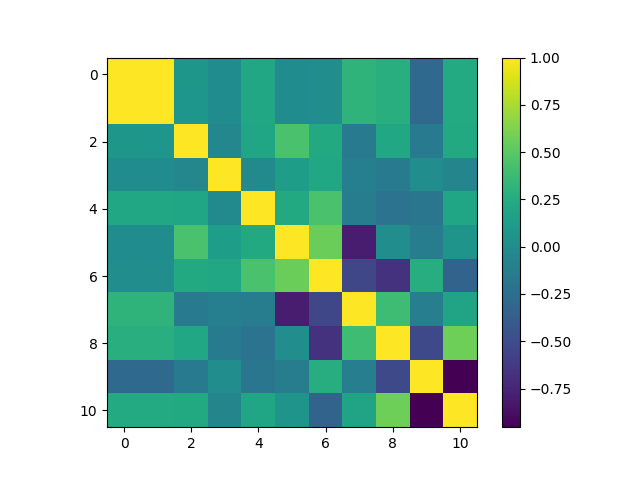

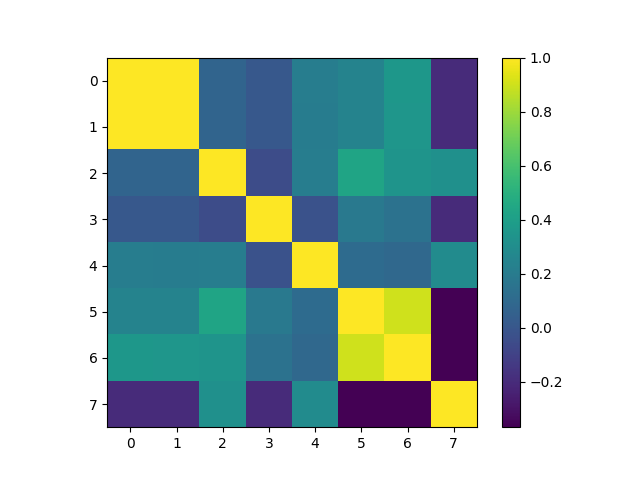

In [8]:
%matplotlib widget
ignore_bad_planets = False
def filter_bad_data(data):
    data_out = []
    for d in data:
        if not d.planet_id in [1349926825, 3786449677, 2554492145, 1267010874, 94572221, 2270815333, 3649218579, 576917580, 2154305089, 2207815333, 2740910036]:
            data_out.append(d)
    return data_out
        
def basics():
    plt.grid(True)
    plt.box(True)
def plot_two_sensors(func, xl, yl, mod):
    _,ax = plt.subplots(1,2,figsize=(12,6))
    plt.sca(ax[0]);basics()
    plt.title('FGS')
    plt.xlabel(xl)
    plt.ylabel(yl)
    sc=func(slice(0,1), 'blue', 'FGS')
    mod()
    kgs.add_cursor(sc)
    
    plt.sca(ax[1]);basics()
    plt.title('AIRS')
    plt.xlabel(xl)
    sc=func(slice(1,283), 'red', 'AIRS')
    mod()
    kgs.add_cursor(sc)
    
    plt.pause(0.001)

def report_extreme_ratios(x,y,name):
    return    
    print(name)
    inds = np.argsort(np.abs(y/x))[::-1]
    for ii in inds[:2]:
        print(f'{inferred_data[ii].planet_id}, ratio:{np.abs(y[ii]/x[ii]):.3f}, x:{x[ii]:.3e}, y:{y[ii]:.3e}, RMS:{kgs.rms(error_matrix[ii,:]):.3e}')
    
    
fname_list = [fname(k) for k in todo.keys()]
#fname_list = ['evaluate_model_Baseline__989.pickle', 'evaluate_model_Baseline__110.pickle', 'evaluate_model_Multi-transit__110.pickle']
for f in fname_list:
    (inferred_data,train_data_here,model,_) = kgs.dill_load(f)
    if ignore_bad_planets:
        inferred_data = filter_bad_data(inferred_data)
        train_data_here = filter_bad_data(train_data_here)
    else:
        train_data_here = train_data_here
    #model.bias_a[0]+=0.006
    #model.bias_a[1]-=0.0002
    #inferred_data = model.infer(train_data)
    
    
    print(f)
    print(model.bias_a)
    print(model.bias_b)
    print(model.sigma_offset)
    print(model.sigma_fudge_FGS, model.sigma_fudge_AIRS_mean, model.sigma_fudge_AIRS_var)
    
    print(kgs.score_metric(inferred_data, train_data_here,print_results=True))
    print('')
    
    
    
    
    #try:
    #    print(model.sigma_offset)
    #except: pass
    #print(model.sigma_fudge)    
    #kgs.list_attrs(model)
    #kgs.score_metric(inferred_data, train_data_here)
    print('')
    #print('3')
    #kgs.score_metric(inferred_data[:3], train_data_here[:3]) 
    #print('')
    print('No fudge')
    #model.sigma_fudge = [1,1]
    #try: model.sigma_offset = [0,0]
    #except: pass
    #model.bias_a = [1,1]
    #model.bias_b = [0,0]
    # print('!!!')
    model.sigma_offset = [0,0]
    model.sigma_fudge_FGS = 1.
    model.sigma_fudge_AIRS_mean = 1.
    model.sigma_fudge_AIRS_var = 1.
    inferred_data = model.infer(train_data_here)
    if ignore_bad_planets:
        inferred_data = filter_bad_data(inferred_data)
    kgs.score_metric(inferred_data, train_data_here)     
    error_matrix = np.array([d.spectrum - t.spectrum for d,t in zip(inferred_data,train_data_here)])
    true_matrix = np.array([t.spectrum for d,t in zip(inferred_data,train_data_here)])
    
#     def plot_prediction_vs_true(slic, col, name):
#         x = np.mean(true_matrix[:,slic],1)
#         y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)
#         return sc
        
#     plot_two_sensors(plot_prediction_vs_true, 'True value (mean)', 'Prediction error (mean)', lambda:0)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = [np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data]
#         y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)
#         return(sc)
#     def mod():
#         plt.axline((0,0), slope=3, color='black')
#         plt.axline((0,0), slope=-3, color = 'black')        
#     plot_two_sensors(plot_mean_error_vs_sigma, 'Sigma prediction (mean)', 'Prediction error (mean)', mod)
    
# #     def plot_mean_error_vs_sigma(slic,col, name):
# #         x = np.mean(true_matrix[:,slic],1)
# #         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
# #         plt.scatter(x,y,color = col)
# #         report_extreme_ratios(x,y,name)    
# #     plot_two_sensors(plot_mean_error_vs_sigma, 'True value (mean)', 'Prediction error / sigma (mean)', lambda:0)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = np.std(true_matrix[:,1:],1)
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS variation', 'Prediction error / sigma (mean)', lambda:0)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = [d.diagnostics['simple_residual_diff_AIRS'] for d in inferred_data]
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS residual ratio', 'Prediction error / sigma (mean)', lambda:0)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = [d.diagnostics['simple_residual_diff_FGS'] for d in inferred_data]
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         #print(y[934])
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'FGS residual ratio', 'Prediction error / sigma (mean)', lambda:0)
    
#     plt.figure(); basics()
#     plt.title('AIRS variation per planet')
#     plt.xlabel('Sigma prediction')
#     plt.ylabel('STD error')
#     n=282
#     x=np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
#     y=np.sqrt(np.var(error_matrix[:,1:],1))
#     plt.scatter(x, y, color='red')
#     plt.axline((0,0), slope=1, color='black')
#     report_extreme_ratios(x,y,'AIRS variation')    
#     plt.pause(0.001)
    
# #     def plot_mean_error_vs_sigma(slic,col, name):
# #         x = np.mean(true_matrix[:,slic],1)
# #         y = np.sqrt(np.var(error_matrix[:,1:],1)) / np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
# #         plt.scatter(x,y,color = col)
# #         report_extreme_ratios(x,y,name)    
# #     plot_two_sensors(plot_mean_error_vs_sigma, 'True value (mean)', 'Prediction error / sigma (AIRS variation)', lambda:0)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = np.std(true_matrix[:,1:],1)
#         y = np.sqrt(np.var(error_matrix[:,1:],1)) / np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
#         sc=plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS variation', 'Prediction error / sigma (AIRS variation)', lambda:0)
    
#     for ii in range(8):
#         def plot_mean_error_vs_sigma(slic,col, name):
#             x = [d.diagnostics['transit_params_gp_par'][ii] for d in inferred_data]
#             y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#             #y = np.mean(error_matrix[:,slic],1)
#             sc=plt.scatter(x,y,color = col)
#             #print(y[934])
#             report_extreme_ratios(x,y,name)    
#             return sc
#         plot_two_sensors(plot_mean_error_vs_sigma, f'Transit param {ii}', 'Prediction error / sigma (mean)', lambda:0)
        
#     for ii in range(7):
#         if ii==4:
#             continue
#         def plot_mean_error_vs_sigma(slic,col, name):
#             x = [d.diagnostics['transit_params_gp'][0].to_x()[ii] for d in inferred_data]
#             y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#             #y = np.mean(error_matrix[:,slic],1)
#             sc=plt.scatter(x,y,color = col)
#             #print(y[934])
#             report_extreme_ratios(x,y,name)    
#             return sc
#         plot_two_sensors(plot_mean_error_vs_sigma, f'Transit param FGS {ii}', 'Prediction error / sigma (mean)', lambda:0)
        
#     for ii in np.arange(5,7):
#         def plot_mean_error_vs_sigma(slic,col, name):
#             x = [d.diagnostics['transit_params_gp'][1].to_x()[ii] for d in inferred_data]
#             y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#             #y = np.mean(error_matrix[:,slic],1)
#             sc=plt.scatter(x,y,color = col)
#             #print(y[934])
#             report_extreme_ratios(x,y,name)    
#             return sc
#         plot_two_sensors(plot_mean_error_vs_sigma, f'Transit param AIRS {ii}', 'Prediction error / sigma (mean)', lambda:0)
    
    # def plot_mean_error_vs_sigma(slic,col, name):
    #     x = [d.diagnostics['transit_params_gp'][1].t0-d.diagnostics['transit_params_gp'][0].t0 for d in inferred_data]
    #     y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
    #     #y = np.mean(error_matrix[:,slic],1)
    #     sc=plt.scatter(x,y,color = col)
    #     #print(y[934])
    #     report_extreme_ratios(x,y,name)    
    #     return sc
    # plot_two_sensors(plot_mean_error_vs_sigma, f't0 diff', 'Prediction error / sigma (mean)', lambda:0)
    
    mat = np.stack([d.diagnostics['transit_params_gp_par'] for d in inferred_data])[:,:,0]
    mat.shape
    
    plt.figure()
    plt.imshow(np.corrcoef(mat.T))
    plt.colorbar()
    #sns.pairplot(pd.DataFrame(mat), diag_kind="hist", corner=True, height=1.5)


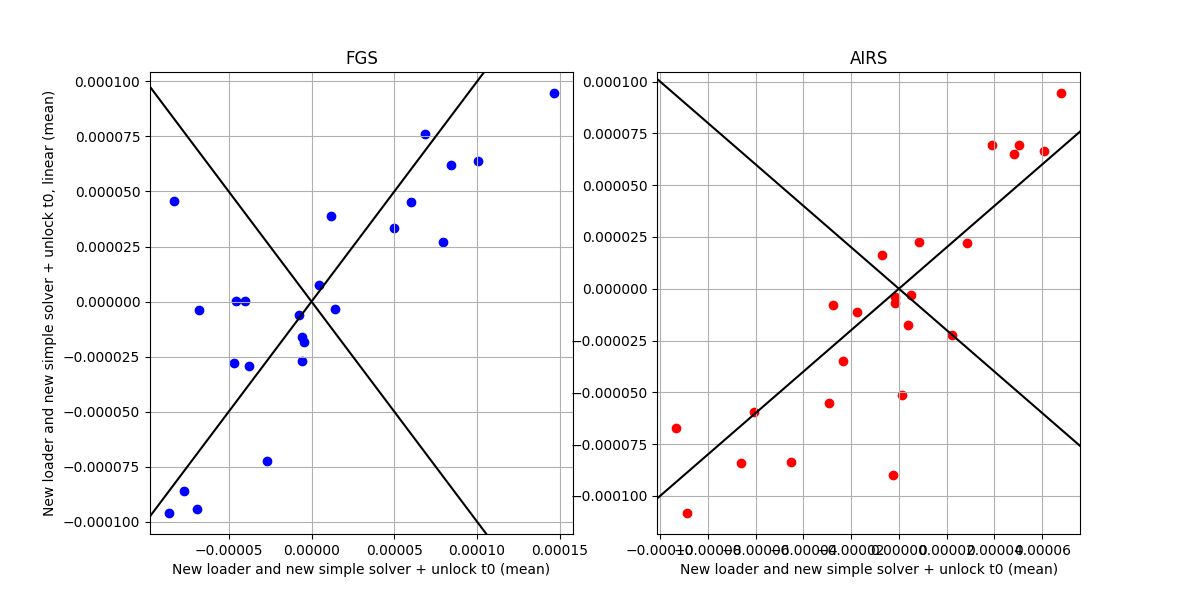

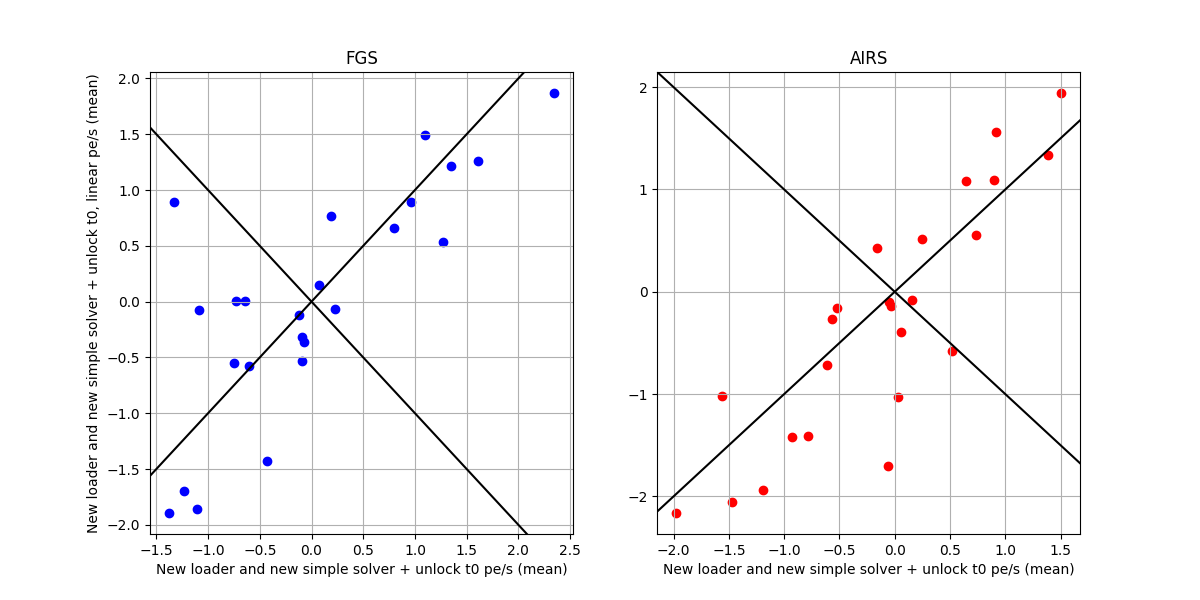

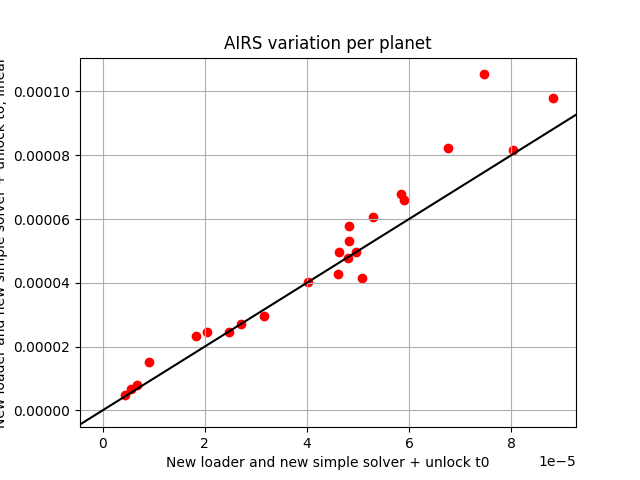

In [9]:
compare1= list(todo.keys())[0]
data1 = kgs.dill_load(fname(compare1))[0]
if ignore_bad_planets:
    data1 = filter_bad_data(data1)
for k,v in todo.items():    
    compare2= k
    if compare2==compare1:
        continue    
    data2 = kgs.dill_load(fname(compare2))[0]
    if ignore_bad_planets:
        data2 = filter_bad_data(data2)
        train_data_here = filter_bad_data(train_data)
    else:
        train_data_here = train_data           
    error1 = np.array([d.spectrum - t.spectrum for d,t in zip(data1,train_data_here)])
    error2 = np.array([d.spectrum - t.spectrum for d,t in zip(data2,train_data_here)])
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(error1[:,slic],1)
        y = np.mean(error2[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        #kgs.add_cursor(sc)

    plot_two_sensors(plot_prediction_vs_true, compare1+' (mean)', compare2+' (mean)', lambda:(plt.axline((0,0),slope=1,color='black'),plt.axline((0,0),slope=-1,color='black')))
    
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(error1[:,slic],1)/np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in data1])
        y = np.mean(error2[:,slic],1)/np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in data2])
        #print(x[934],y[934])
        sc=plt.scatter(x,y,color = col)
        #kgs.add_cursor(sc)
    plot_two_sensors(plot_prediction_vs_true, compare1+' pe/s (mean)', compare2+' pe/s (mean)', lambda:(plt.axline((0,0),slope=1,color='black'),plt.axline((0,0),slope=-1,color='black')))

    plt.figure(); basics()
    plt.title('AIRS variation per planet')
    plt.xlabel(compare1)
    plt.ylabel(compare2)
    x=np.sqrt(np.var(error1[:,1:],1))
    y=np.sqrt(np.var(error2[:,1:],1))
    plt.scatter(x, y, color='red')
    plt.axline((0,0), slope=1, color='black')
    plt.pause(0.001)

In [10]:
# import subprocess

# # Hibernate Windows
# subprocess.run(
#     ["/mnt/c/Windows/System32/shutdown.exe", "/a"],  # add "/f" to force-close apps
#     check=True
# )
# subprocess.run(
#     ["/mnt/c/Windows/System32/shutdown.exe", "/h"],  # add "/f" to force-close apps
#     check=True
# )

In [11]:
train_data[7].planet_id

30291666

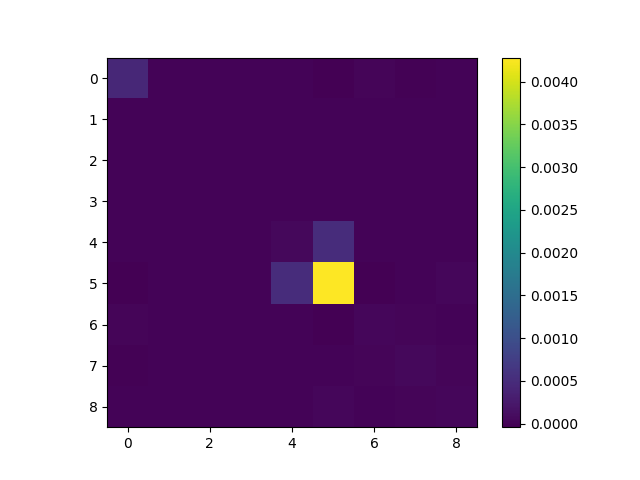

In [12]:
plt.figure()
cov = inferred_data[3].diagnostics['transit_params_gp_par_cov']
plt.imshow(cov)
plt.colorbar()

In [13]:
inferred_data[0].diagnostics

{'training_spectrum': array([0.01829066, 0.01808844, 0.01808703, 0.01808523, 0.01808411,
        0.0180839 , 0.01808416, 0.01808444, 0.01808458, 0.01808422,
        0.01808277, 0.01807999, 0.01807626, 0.01807207, 0.01806768,
        0.01806348, 0.01806041, 0.01805973, 0.01806242, 0.01806904,
        0.01807926, 0.01809136, 0.01810262, 0.01811076, 0.01811514,
        0.01811688, 0.01811851, 0.01812254, 0.01812924, 0.01813579,
        0.01813868, 0.01813702, 0.0181334 , 0.01813108, 0.01813111,
        0.01813231, 0.01813329, 0.01813392, 0.01813486, 0.01813611,
        0.01813671, 0.01813584, 0.01813406, 0.01813265, 0.01813215,
        0.01813184, 0.01813088, 0.01812916, 0.01812738, 0.01812641,
        0.01812633, 0.01812591, 0.01812366, 0.01811942, 0.01811462,
        0.01811073, 0.0181081 , 0.01810615, 0.01810429, 0.01810226,
        0.01810007, 0.01809799, 0.01809638, 0.01809549, 0.01809522,
        0.01809517, 0.01809472, 0.01809355, 0.01809185, 0.01809018,
        0.01808899, 0.01808